<H1><center>Predict future sales</center></H1>

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.



### Data fields description:
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* date - date in format dd/mm/yyyy
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

In [ ]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Loading data

In [ ]:
test = pd.read_csv('../input/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('../input/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('../input/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('../input/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('../input/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

### Join data sets

In [131]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

### Let's take a look at the raw data

In [132]:
print('Train rows: ', train.shape[0])
print('Train columns: ', train.shape[1])

Train rows:  2935849
Train columns:  10


In [133]:
train.head().T

,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


In [134]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.62,1.24,40.00
std,9.42,16.23,6324.30,1726.44,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


### Time period

In [135]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


### Data preprocessing
We are asked to predict total sales for every product and store in the next month, and our data is given by day, so let's remove unwanted columns and aggregate the data by month.

In [136]:
# Select only usefeul features (here I won't be using the text features).
train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]
# # Group by month in this case "date_block_num" and aggregate features.
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum'], 'item_cnt_day':['sum','count']})
# # Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt', 'transactions']

### New dataset

In [137]:
train_monthly.head(10).T

,0,1,2,3,4,5,6,7,8,9
date_block_num,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
shop_id,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
item_category_id,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5573.00,5575.00,5576.00,5609.00,5612.00,5623.00,5627.00,5629.00,5630.00
item_price,7932.00,560.00,2418.00,11155.00,2381.00,3623.00,294.00,4120.00,15400.00,2060.00
item_cnt,10.00,1.00,4.00,5.00,1.00,1.00,1.00,2.00,9.00,1.00
transactions,6.00,1.00,3.00,5.00,1.00,1.00,1.00,2.00,8.00,1.00


In [138]:
# Extract time based features.
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

### EDA

In [139]:
# Grouping data for EDA.
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

### How sales behaves along the year?

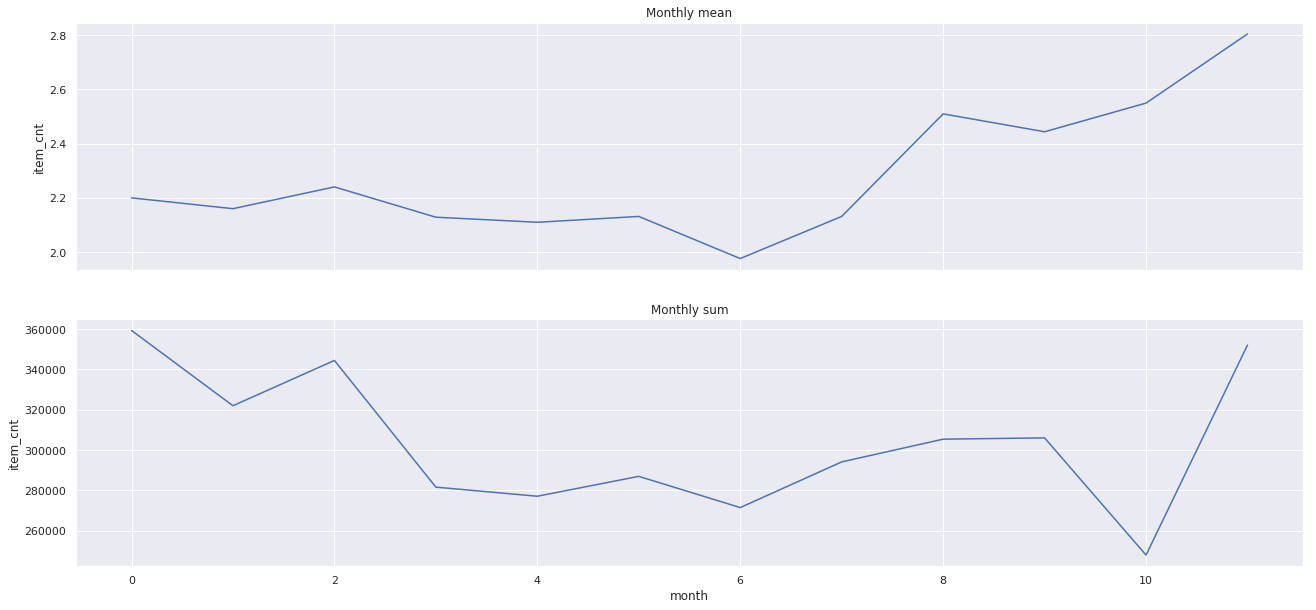

In [140]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

### What category sells more?

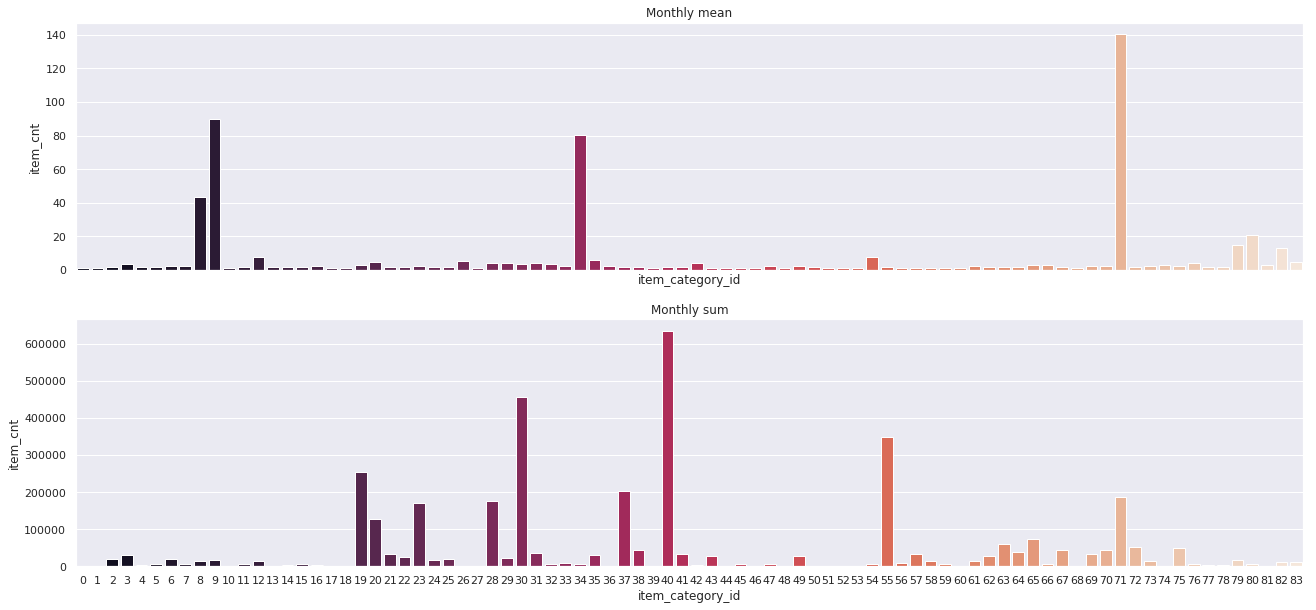

In [141]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

### What shop sells more?

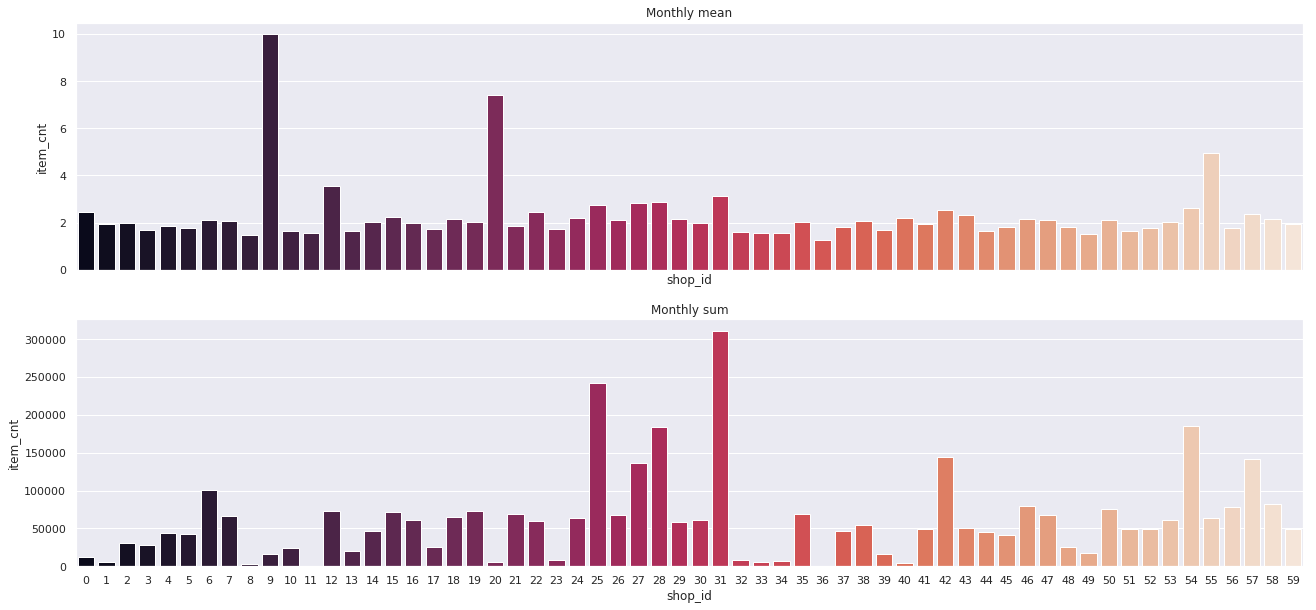

In [142]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

### Checking for outliers

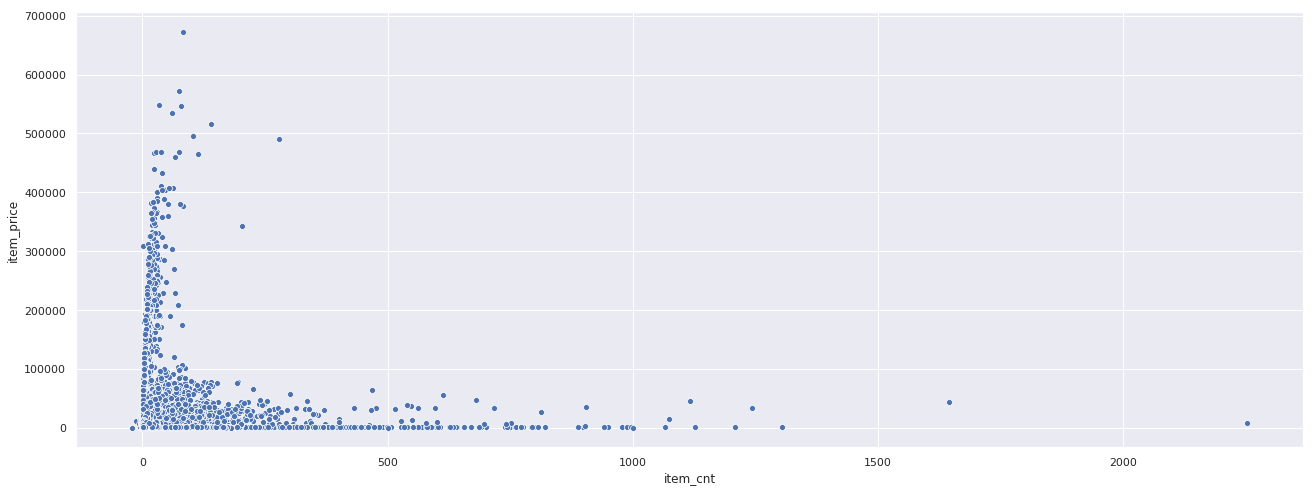

In [143]:
plt.subplots(figsize=(22, 8))
sns.scatterplot(x="item_cnt", y="item_price", data=train_monthly, palette="rocket")
plt.show()

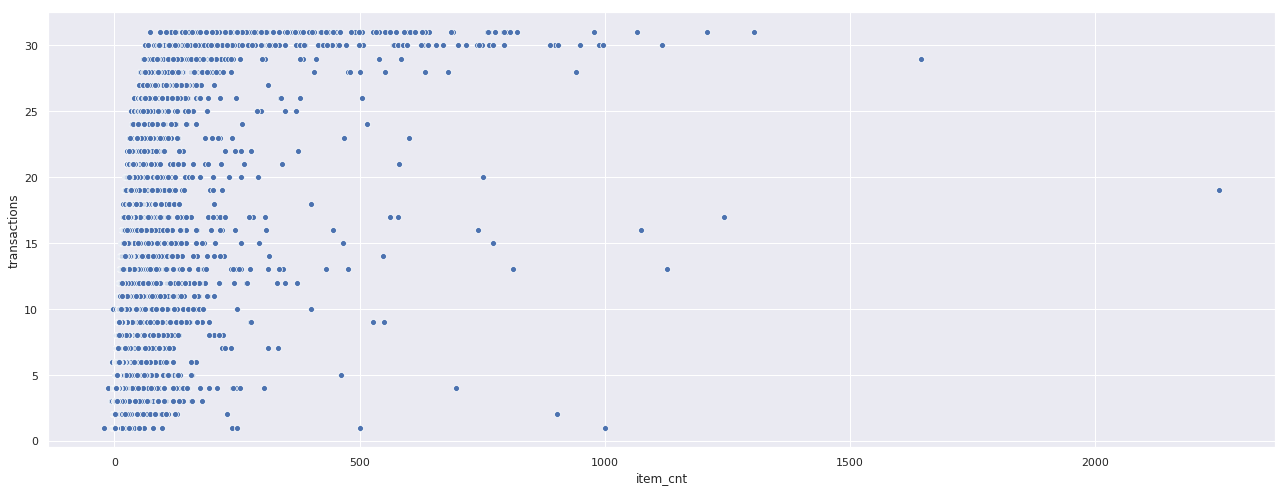

In [144]:
plt.subplots(figsize=(22, 8))
sns.scatterplot(x="item_cnt", y="transactions", data=train_monthly, palette="rocket")
plt.show()

#### Removing outliers
I'll treat "item_cnt" >= 300, "item_price" >= 500000 and "transactions" >= 35 as outliers, so I'll remove them.

In [145]:
train_monthly = train_monthly.query('item_cnt < 300 and item_price < 500000 and transactions < 35')

### Creating the label
Our label will be the "item_cnt" of the next month

In [146]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

### Feature engineering

In [147]:
# Get the unitary item prices
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']

In [148]:
# Group based features.
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')

In [149]:
# How much each item's price changed from its (low/high) historical price.
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

In [150]:
# Rolling window based features [window = 12 months].
# Min values
f_min = lambda x: x.rolling(window=12, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=12, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=12, min_periods=1).mean()
# Median value
f_median = lambda x: x.rolling(window=12, min_periods=1).median()
# Stardad deviation value
f_std = lambda x: x.rolling(window=12, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_median, f_std]
function_name = ['min', 'max', 'mean', 'median', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

In [280]:
# Lag based features.
lag_list = [1, 2, 6, 12]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

### Dataset after feature engineering

In [281]:
train_monthly.head(10).T

,0,1,2,3,4,5,6,7,8,9
date_block_num,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
shop_id,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
item_category_id,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5573.00,5575.00,5576.00,5609.00,5612.00,5623.00,5627.00,5629.00,5630.00
item_price,7932.00,560.00,2418.00,11155.00,2381.00,3623.00,294.00,4120.00,15400.00,2060.00
item_cnt,10.00,1.00,4.00,5.00,1.00,1.00,1.00,2.00,9.00,1.00
transactions,6.00,1.00,3.00,5.00,1.00,1.00,1.00,2.00,8.00,1.00
year,2013.00,2013.00,2013.00,2013.00,2013.00,2013.00,2013.00,2013.00,2013.00,2013.00
month,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
item_cnt_month,11.00,1.00,nan,2.00,1.00,nan,3.00,4.00,5.00,1.00


### Data leakages

About data leakages the only thing that I'll be doing here is to use only the "shop_id" and "item_id" that appear on the test set.

In [282]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
lk_train = train_monthly[train_monthly['shop_id'].isin(test_shop_ids)]
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

In [283]:
print('Data set size before leaking:', train_monthly.shape[0])
print('Data set size after leaking:', lk_train.shape[0])

Data set size before leaking: 1608911
Data set size after leaking: 600014


### Train/validation split
* As we know the test set in on the future, so we should try to simulate the same distribution on our train/validation split.
* Our train set will be the first 28 blocks, validation will be last 5 blocks and test will be block 33.

In [284]:
train_set = lk_train.query('date_block_num < 28').copy()
validation_set = lk_train.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = lk_train.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

Train set records: 404569
Validation set records: 83350
Test set records: 28675


In [285]:
print('Train set records: %s (%.f%% of data)' % (train_set.shape[0], ((train_set.shape[0]/lk_train.shape[0])*100)))
print('Validation set records: %s (%.f%% of data)' % (validation_set.shape[0], ((validation_set.shape[0]/lk_train.shape[0])*100)))

Train set records: 404569 (67% of data)
Validation set records: 83350 (14% of data)


In [286]:
# Train and validation sets/labels. 
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [287]:
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

### Build test set
We want to predict for "date_block_num" 34 so our test set will be block 33 and our predictions should reflect block 34 values. In other words we use block 33 because we want to forecast values for block 34.

In [288]:
X_test = pd.merge(test, train_monthly.drop_duplicates(subset=['shop_id', 'item_id'], keep='last'), on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

In [289]:
# Replace missing values with the median of each shop.
columns_input = list(set(X_test.columns) - set(['shop_id', 'item_id', 'year', 'month']))

for shop_id in X_test['shop_id'].unique():
    for column in X_test.columns:
        shop_median = X_test[(X_test['shop_id'] == shop_id)][column].median()
        X_test.loc[(X_test[column].isnull()) & (X_test['shop_id'] == shop_id), column] = shop_median

In [290]:
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

### Modeling the data
* Data normalization  won't be done here since I'm using a tree based model.

### Catboost

In [442]:
cat_features = [0, 1, 5, 6]

catboost_model = CatBoostRegressor(
    iterations=500,
    random_seed=0,
    od_type='Iter',
    od_wait=20,
    verbose=50,
    depth=10
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_validation, Y_validation)
)

0:	learn: 6.9231150	test: 5.0908673	best: 5.0908673 (0)	total: 372ms	remaining: 3m 5s
50:	learn: 3.6351040	test: 2.8489455	best: 2.8489455 (50)	total: 20.7s	remaining: 3m 1s
100:	learn: 3.0279409	test: 2.6514316	best: 2.6514316 (100)	total: 41.3s	remaining: 2m 43s
150:	learn: 2.8218377	test: 2.6346992	best: 2.6333272 (146)	total: 1m 2s	remaining: 2m 24s
200:	learn: 2.7132848	test: 2.6260250	best: 2.6251109 (197)	total: 1m 24s	remaining: 2m 5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 2.625110899
bestIteration = 197

Shrink model to first 198 iterations.


In [443]:
print('Model is fitted: ' + str(catboost_model.is_fitted()))
print('Model params:', catboost_model.get_params())

Model is fitted: True
Model params: {'verbose': 50, 'random_seed': 0, 'od_type': 'Iter', 'od_wait': 20, 'loss_function': 'RMSE', 'depth': 10, 'iterations': 500}


In [444]:
# Catboost predictions
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

### Let's see how catboost performed with this "prediction x label" plot.
The closer the points are to the middle dashed line the better are the predictions.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


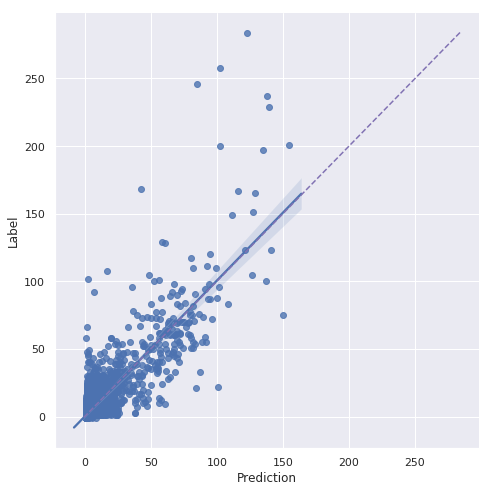

In [445]:
def model_performance_sc_plot(predictions, labels):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_val_df = pd.DataFrame({"Label":labels})
    performance_val_df["Prediction"] = predictions
    # Plot data
    sns.lmplot(y="Label", x="Prediction", data=performance_val_df, height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.show()
    
model_performance_sc_plot(catboost_val_pred, Y_validation)

### Random forest

In [446]:
# Use only part of feature on random forest.
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'month', 'item_cnt_min', 'item_cnt_max', 'item_cnt_mean',
               'item_cnt_std', 'item_cnt_shifted1']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [447]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=9, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [448]:
# Random forest predictions
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [449]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Train rmse: 2.880549521232911
Validation rmse: 2.752132276079915


### Let's see how random forest performed with this "prediction x label" plot.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


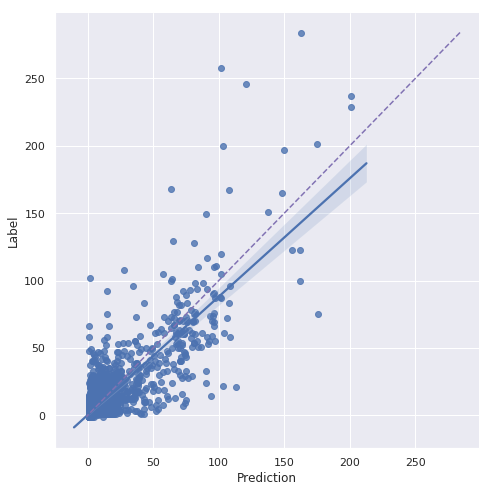

In [450]:
model_performance_sc_plot(rf_val_pred, Y_validation)

### KNN Regressor

In [451]:
# Use only part of feature on KNN.
knn_features = ['shop_id', 'item_id', 'item_cnt', 'year', 'month', 'item_cnt_mean',
                   'item_cnt_std', 'item_cnt_shifted1', 'item_cnt_shifted2',
                   'item_cnt_shifted6', 'item_cnt_shifted12']
knn_train = X_train[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]

In [452]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=13, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
          weights='uniform')

In [453]:
# Knn predictions
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

In [454]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, knn_val_pred)))

Train rmse: 3.1102797214934896
Validation rmse: 2.927690927951672


### Let's see how knn performed with this "prediction x label" plot.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


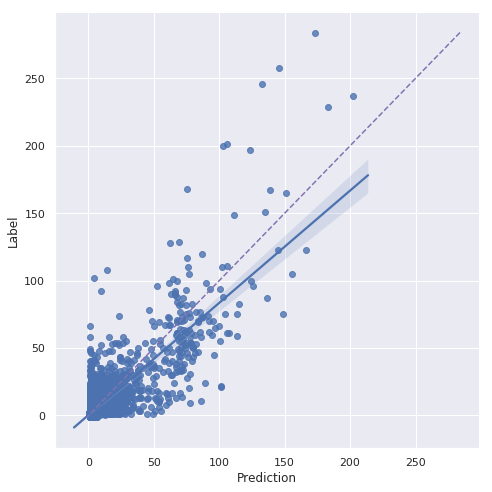

In [455]:
model_performance_sc_plot(knn_val_pred, Y_validation)

### Create new datasets with the predictions from first level models

In [456]:
# Dataset that will be the train set of the ensemble model.
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['random_forest'] = rf_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = Y_validation.values
first_level.head(10)

,catboost,random_forest,knn,label
0,1.52,1.38,1.22,1
1,1.79,1.86,1.78,1
2,1.28,1.21,2.22,1
3,1.37,1.40,1.67,1
4,1.92,1.83,1.67,1
5,2.41,1.84,2.56,1
6,2.43,1.85,2.67,1
7,1.31,1.37,1.11,1
8,1.26,1.21,0.89,1
9,3.25,2.43,3.00,3


In [457]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(catboost_test_pred, columns=['catboost'])
first_level_test['random_forest'] = rf_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

,catboost,random_forest,knn
0,1.37,1.56,1.89
1,1.24,1.23,2.67
2,2.21,1.68,1.44
3,1.24,1.55,1.67
4,1.24,1.23,1.22


### Ensembling

To combine the other models (1st level) predictions, I'll use a simple linear regression.

#### Stacking architecture:
* 1st level:
    * Catboost
    * Random forest
    * KNN
* 2nd level;
    * Linear Regression

In [458]:
meta_model = LinearRegression()
# Drop label from data set.
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_validation)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [459]:
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_validation)))

Train rmse: 2.562854087142496


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


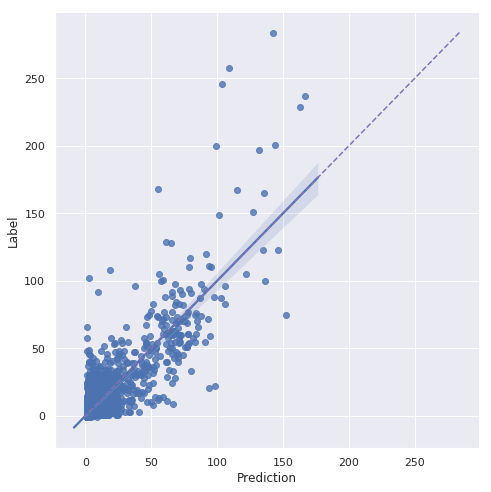

In [460]:
model_performance_sc_plot(ensemble_pred, Y_validation)

In [461]:
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('submission_clipped.csv', index=False)

In [462]:
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions
prediction_df.to_csv('submission.csv', index=False)
prediction_df.head(10)

,ID,item_cnt_month
0,0,1.55
1,1,1.57
2,2,1.84
3,3,1.44
4,4,1.23
5,5,1.65
6,6,1.94
7,7,1.72
8,8,2.43
9,9,1.26
